Построение и настройка модели случайного леса. Визуализация важности признаков.
Цель: В этом задании вам предстоит научиться предсказывать судьбу животных в приюте. Найдут ли их прежние хозяева? Заберут ли их домой к новым? Или судьба будет не так благосклонна? Ответ найдём в лесу
1. Скачиваем данные вот отсюда - https://www.kaggle.com/c/shelter-animal-outcomes/data
2. Знакомимся с данными, целевой переменной будет OutcomeType, соответственно OutcomeSubType необходимо выкинуть из данных
3. Как можно заметить, почти все переменные текстовые/категориальные - смиряемся с тем, что нужно будет пилить много новых признаков
4. Делим данные на train/test, чтобы все преобразования, связанные с построением новых признаков, мы обучали только на трейне, а применяли уже везде
5. Выкидываем ID, потому что не нужОн, всё, что категориальное и с небольшим числом уникальных значений кодируем при помощи LabelEncoder (заодно можно объяснить, почему достаточно использовать LabelEncoder вместо OneHotEncoder)
6. Остальные текстовые переменные, где очень много уникальных значений (вроде имени или цвета), можно закодировать по вашему вкусу, можно использовать частоту встречаемости, можно попробовать закодировать отдельные цвета LabelEncoder, и т.д.
7. Наконец, очень полезно будет на основании AgeuponOutcome создать обычную непрерывную переменную - возраст животного, а из переменной DateTime подергать отдельно год, месяц и день недели
8. Делаем бейзлайн на основании частоты встречаемости каждого класса, а затем учим лес и сравниваем качество (полезно будет смотреть на confusion_matrix и classification_report)
9. Настраиваем основные параметры леса при помощи randomsearch - n_estimators, max_depth, и еще можно class_weight
10. Визуализируем важность признаков
11. Вы великолепны

Критерии оценки: Вся предобработка - 6 баллов
Модельки и важность - еще 4 балла

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


In [5]:
data.describe(include = 'O')

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A682957,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [6]:
data.OutcomeType.unique()

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'],
      dtype=object)

In [7]:
data.groupby(by = 'OutcomeType')['AnimalID'].count()

OutcomeType
Adoption           10769
Died                 197
Euthanasia          1555
Return_to_owner     4786
Transfer            9422
Name: AnimalID, dtype: int64

In [8]:
data.OutcomeSubtype.unique()

array([nan, 'Suffering', 'Foster', 'Partner', 'Offsite', 'SCRP',
       'Aggressive', 'Behavior', 'Rabies Risk', 'Medical', 'In Kennel',
       'In Foster', 'Barn', 'Court/Investigation', 'Enroute', 'At Vet',
       'In Surgery'], dtype=object)

In [9]:
data.SexuponOutcome.unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

Что можно увидеть при первом взгляде на данные: 
- все колонки имеют тип object, но не факт, что для каждой из них этот тип правильный. 
- переменная SexuponOutcome может быть легко поделена на две переменные, т.к. содержит следующую информацию: пол животного, факт стерилизации. Кроме того, в поле содержатся пропуски, но они спрятаны за пользовательскими значениями "Unknown" и "nan".
- целевая переменная имеет всего 5 значений, поэтому перед нами стоит задача мультиклассовой классификации.

По условию задания колонку OutcomeSubtype мы выкидываем, а OutcomeType считаем целевой.

In [10]:
data[data['AnimalType']=='Dog'].groupby(by = 'Breed')['AnimalID'].count().sort_values(ascending = False)[0:50]

Breed
Pit Bull Mix                          1906
Chihuahua Shorthair Mix               1766
Labrador Retriever Mix                1363
German Shepherd Mix                    575
Australian Cattle Dog Mix              367
Dachshund Mix                          318
Boxer Mix                              245
Miniature Poodle Mix                   233
Border Collie Mix                      229
Australian Shepherd Mix                163
Rat Terrier Mix                        157
Catahoula Mix                          157
Jack Russell Terrier Mix               146
Yorkshire Terrier Mix                  143
Chihuahua Longhair Mix                 142
Siberian Husky Mix                     138
Miniature Schnauzer Mix                136
Beagle Mix                             124
Rottweiler Mix                         113
American Bulldog Mix                   109
Cairn Terrier Mix                      102
Shih Tzu Mix                           100
Chihuahua Shorthair/Dachshund           98
Austr

По всей видимости, приписка Mix в переменной Breed говорит о том, что порода смешанная. Попробуем вытащить её.

In [11]:
def get_mix(x):
    x = str(x)
    if x.find('Mix') >= 0: return 'mix'
    return 'not'
data['mix_breed'] = data.Breed.apply(get_mix)

Остальные породы разобьем по размерам собак, максимально, насколько это возможно.

In [12]:
def get_dogsize(x):
    x = str(x)
    if x.find('Chihuahua') >= 0: return 'small'
    if x.find('Jack Russell Terrier') >= 0: return 'small'
    if x.find('Miniature') >= 0: return 'small'
    if x.find('Shih Tzu') >= 0: return 'small'
    if x.find('Yorkshire Terrier') >= 0: return 'small'
    if x.find('Cairn Terrier') >= 0: return 'small'
    if x.find('Maltese')>=0: return 'small'
    if x.find('Pug')>=0: return 'small'
     
    if x.find('Golden Retriever') >= 0: return 'large'
    if x.find('Labrador') >= 0: return 'large'
    if x.find('Pyrenee') >= 0: return 'large'
    if x.find('Greyhound') >= 0: return 'large'
    if x.find('Border Collie') >= 0: return 'large'
    if x.find('Australian Shepherd') >= 0: return 'large' 
    if x.find('German Shepherd') >= 0: return 'large'    
    if x.find('Husky') >= 0: return 'large'
    if x.find('Boxer') >= 0: return 'large'
    if x.find('German Shepherd') >= 0: return 'large' 
    if x.find('Staffordshire') >= 0: return 'large'
    if x.find('Catahoula') >= 0: return 'large'
    if x.find('Black Mouth')>=0: return 'large'
    if x.find('Chow Chow')>=0: return 'large'
    if x.find('Doberman Pinsch')>=0: return 'large'
    if x.find('Plott Hound')>=0: return 'large'
    if x.find('Anatol Shepherd')>=0: return 'large'
        
    if x.find('Terrier') >= 0: return 'medium'
    if x.find('Bulldog') >= 0: return 'medium'
    if x.find('Corgi') >= 0: return 'medium'
    if x.find('Poodle') >= 0: return 'medium'
    if x.find('Beagle') >= 0: return 'medium'
    if x.find('Bulldog') >= 0: return 'medium'
    if x.find('Dachshund') >= 0: return 'medium'
    if x.find('Australian Cattle') >= 0: return 'medium'
    if x.find('Rat Terrier') >= 0: return 'medium'

    return 'Unknown'
data['animalsize'] = data.Breed.apply(get_dogsize)

Всех кошек автоматом назначим в малый размер.

In [13]:
data['animalsize']= np.where(data['AnimalType']=='Cat', 'small', data['animalsize'])

In [14]:
data.groupby(by = 'animalsize')['AnimalID'].count()

animalsize
Unknown     3778
large       5416
medium      2162
small      15373
Name: AnimalID, dtype: int64

Вытащим пол и информацию о стерилизации животного.

In [15]:
# functions to get new parameters from the column
def get_sex(x):
    x = str(x)
    if x.find('Male') >= 0: return 'male'
    if x.find('Female') >= 0: return 'female'
    return 'unknown'
data['sex'] = data.SexuponOutcome.apply(get_sex)
def get_neutered(x):
    x = str(x)
    if x.find('Spayed') >= 0: return 'neutered'
    if x.find('Neutered') >= 0: return 'neutered'
    if x.find('Intact') >= 0: return 'intact'
    return 'unknown'
data['neutered_fact'] = data.SexuponOutcome.apply(get_neutered)

Теперь посмотрим на окрас животных.

In [16]:
data.groupby(by = 'Color')['AnimalID'].count().sort_values(ascending = False)

Color
Black/White                    2824
Black                          2292
Brown Tabby                    1635
Brown Tabby/White               940
White                           931
Brown/White                     884
Orange Tabby                    841
Tan/White                       773
Tricolor                        752
Blue/White                      702
Black/Tan                       672
White/Black                     643
Brown                           639
Tan                             628
White/Brown                     569
Tortie                          530
Calico                          517
Orange Tabby/White              455
Blue                            450
Brown Brindle/White             450
Black/Brown                     436
Blue Tabby                      433
White/Tan                       389
Red                             337
Torbie                          335
Brown/Black                     333
Red/White                       331
Blue Tabby/White      

Вытащим 20 самых частых окрасов. Для остальных, более редких окрасов введем переменную "other".

In [17]:
list_frequent_categories = []
n = 0
total = 0
while n<20:
    list_frequent_categories.append(data['Color'].value_counts().index[n])
    total+=data['Color'].value_counts()[n]
    n+=1
print('Percent of these categories at the column [','Color',']: ',round(total/len(data['Color'])*100,2),'%')
print(list_frequent_categories)

Percent of these categories at the column [ Color ]:  67.82 %
['Black/White', 'Black', 'Brown Tabby', 'Brown Tabby/White', 'White', 'Brown/White', 'Orange Tabby', 'Tan/White', 'Tricolor', 'Blue/White', 'Black/Tan', 'White/Black', 'Brown', 'Tan', 'White/Brown', 'Tortie', 'Calico', 'Orange Tabby/White', 'Brown Brindle/White', 'Blue']


In [18]:
def get_color(x):
    x = str(x)
    if x in list_frequent_categories: return x
    else: return 'other'
data['Color_new'] = data.Color.apply(get_color)
data['Color_new'] = np.where(data['Color_new']=='other', data['Color_new'], data['Color'])

In [19]:
data['Color_new'].nunique()

21

In [20]:
def calc_age_in_years(x):
    x = str(x)
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year') > -1: return age 
    if x.find('month')> -1: return age / 12.
    if x.find('week')> -1: return age / 52.
    if x.find('day')> -1: return age / 365.
    else: return 0

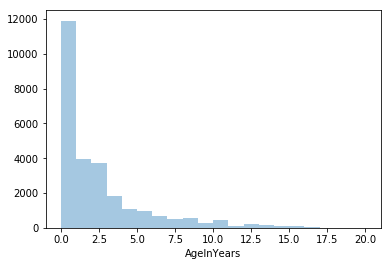

In [21]:
data['AgeInYears'] = data.AgeuponOutcome.apply(calc_age_in_years)
sns.distplot(data.AgeInYears, bins = 20, kde=False)

In [22]:
def calc_age_category(x):
    if x < 0.5: return 'kitten|puppy'
    if x < 3: return 'young'
    if x < 5: return 'young adult'
    if x < 10: return 'adult'
    return 'old'
data['AgeCategory'] = data.AgeInYears.apply(calc_age_category)

In [23]:
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,mix_breed,animalsize,sex,neutered_fact,Color_new,AgeInYears,AgeCategory
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,mix,Unknown,male,neutered,Brown/White,1.000000,young
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,mix,small,female,neutered,other,1.000000,young
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,mix,Unknown,male,neutered,Blue/White,2.000000,young
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,mix,small,male,intact,other,0.057692,kitten|puppy
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,not,small,male,neutered,Tan,2.000000,young


Удалим лишние поля.

In [24]:
data.drop(['AnimalID', 'Name', 'DateTime', 'OutcomeSubtype', 'SexuponOutcome',
           'AgeuponOutcome', 'Breed', 'Color', 'AgeInYears'], axis = 1, 
         inplace = True)

In [25]:
data.head(5)

,OutcomeType,AnimalType,mix_breed,animalsize,sex,neutered_fact,Color_new,AgeCategory
0,Return_to_owner,Dog,mix,Unknown,male,neutered,Brown/White,young
1,Euthanasia,Cat,mix,small,female,neutered,other,young
2,Adoption,Dog,mix,Unknown,male,neutered,Blue/White,young
3,Transfer,Cat,mix,small,male,intact,other,kitten|puppy
4,Transfer,Dog,not,small,male,neutered,Tan,young


!
**Выкидываем ID, потому что не нужОн, всё, что категориальное и с небольшим числом уникальных значений кодируем при помощи LabelEncoder (заодно можно объяснить, почему достаточно использовать LabelEncoder вместо OneHotEncoder)**

Достаточно, а точнее лучше в данном случае будет использовать LabelEncoder, если переменная не только категориальная, но и категории могут быть проранжированы/отсортированы неким образом между собой.
Например, так происходит с нашей переменной размера животного.

In [26]:
data.columns

Index(['OutcomeType', 'AnimalType', 'mix_breed', 'animalsize', 'sex',
       'neutered_fact', 'Color_new', 'AgeCategory'],
      dtype='object')

In [27]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
for i in ['OutcomeType']:
    enc.fit(data[i])
    data[i]=enc.transform(data[i])
data.head()

,OutcomeType,AnimalType,mix_breed,animalsize,sex,neutered_fact,Color_new,AgeCategory
0,3,Dog,mix,Unknown,male,neutered,Brown/White,young
1,2,Cat,mix,small,female,neutered,other,young
2,0,Dog,mix,Unknown,male,neutered,Blue/White,young
3,4,Cat,mix,small,male,intact,other,kitten|puppy
4,4,Dog,not,small,male,neutered,Tan,young


Расшифруем типы OutcomeType, которые у нас имеются:

**0** - Adoption

**1** - Died
    
**2** - Euthanasia

**3** - Return_to_owner

**4** - Transfer

In [28]:
data_nonbinary = pd.get_dummies(data[['AnimalType', 'animalsize', 'sex',
       'neutered_fact', 'AgeCategory', 
         'Color_new', 'mix_breed']])

data = pd.concat((data['OutcomeType'], data_nonbinary), axis = 1)

In [29]:
data.head()

,OutcomeType,AnimalType_Cat,AnimalType_Dog,animalsize_Unknown,animalsize_large,animalsize_medium,animalsize_small,sex_female,sex_male,sex_unknown,...,Color_new_Tan,Color_new_Tan/White,Color_new_Tortie,Color_new_Tricolor,Color_new_White,Color_new_White/Black,Color_new_White/Brown,Color_new_other,mix_breed_mix,mix_breed_not
0,3,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,4,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,0
4,4,0,1,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1


### Параметры

Метод случайного леса реализован в библиотеке машинного обучения scikit-learn двумя классами RandomForestClassifier и RandomForestRegressor.


Полный список параметров случайного леса для задачи регрессии:


**class sklearn.ensemble.RandomForestRegressor**

**n_estimators** — число деревьев в "лесу" (по дефолту – 10)

**criterion** — функция, которая измеряет качество разбиения ветки дерева (по дефолту — "mse" , так же можно выбрать "mae")

**max_features** — число признаков, по которым ищется разбиение. Вы можете указать конкретное число или процент признаков, либо выбрать из доступных значений: "auto" (все признаки), "sqrt", "log2". По дефолту стоит "auto".

**max_depth** — максимальная глубина дерева  (по дефолту глубина не ограничена)

**min_samples_split** — минимальное количество объектов, необходимое для разделения внутреннего узла. Можно задать числом или процентом от общего числа объектов (по дефолту — 2)

**min_samples_leaf** — минимальное число объектов в листе. Можно задать числом или процентом от общего числа объектов (по дефолту — 1)

**min_weight_fraction_leaf** — минимальная взвешенная доля от общей суммы весов (всех входных объектов) должна быть в листе (по дефолту имеют одинаковый вес)

**max_leaf_nodes** — максимальное количество листьев (по дефолту нет ограничения)

**min_impurity_split** — порог для остановки наращивания дерева (по дефолту 1е-7)

**bootstrap** — применять ли бустрэп для построения дерева (по дефолту True)

**oob_score** — использовать ли out-of-bag объекты для оценки R^2 (по дефолту False)

**n_jobs** — количество ядер для построения модели и предсказаний (по дефолту 1, если поставить -1, то будут использоваться все ядра)

**random_state** — начальное значение для генерации случайных чисел (по дефолту его нет, если хотите воспроизводимые результаты, то нужно указать любое число типа int

**verbose** — вывод логов по построению деревьев (по дефолту 0)

**warm_start** — использует уже натренированую модель и добавляет деревьев в ансамбль (по дефолту False)


Для задачи классификации все почти то же самое, мы приведем только те параметры, которыми RandomForestClassifier отличается от RandomForestRegressor


**class sklearn.ensemble.RandomForestClassifier**

**criterion** — поскольку у нас теперь задача классификации, то по дефолту выбран критерий "gini" (можно выбрать "entropy")

**class_weight** — вес каждого класса (по дефолту все веса равны 1, но можно передать словарь с весами, либо явно указать "balanced", тогда веса классов будут равны их исходным частям в генеральной совокупности; также можно указать "balanced_subsample", тогда веса на каждой подвыборке будут меняться в зависимости от распределения классов на этой подвыборке.
)

Далее рассмотрим несколько параметров, на которые в первую очередь стоит обратить внимание при построении модели:


**n_estimators** — число деревьев в "лесу"

**criterion** — критерий для разбиения выборки в вершине

**max_features** — число признаков, по которым ищется разбиение

**min_samples_leaf** — минимальное число объектов в листе

**max_depth** — максимальная глубина дерева

Открытый курс машинного обучения: https://habr.com/ru/company/ods/blog/324402/

In [30]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [31]:
X_train, X_test, y_train, y_test  = train_test_split(data.drop('OutcomeType', axis = 1), data['OutcomeType'], test_size = 0.3,
                                                    stratify = data['OutcomeType'], random_state = 11)

# Тренировка baseline модели

model = RandomForestClassifier(n_jobs = -1, random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Отчёты о точности работы

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

D:\programs\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.62      0.81      0.70      3231
           1       0.20      0.02      0.03        59
           2       0.26      0.10      0.15       466
           3       0.42      0.33      0.37      1436
           4       0.70      0.61      0.65      2827

   micro avg       0.61      0.61      0.61      8019
   macro avg       0.44      0.37      0.38      8019
weighted avg       0.59      0.61      0.59      8019

0.6066841252026437


In [32]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)>

In [33]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'n_estimators': [1, 3, 5, 7, 9, 11, 15], 
              'criterion': ['gini', 'entropy'],
              'class_weight': [None, 'balanced_subsample', 'balanced'],
              'max_features': [1, 3, 4, 6, 8, 15, 30], 
              'min_samples_leaf': [1,2,3, 5, 10], 
              'max_depth': [2, 5, 10, 20], 
                }
rfc = RandomForestClassifier( random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, verbose=1)
gcv.fit(X_train, y_train)

D:\programs\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 5880 candidates, totalling 17640 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 11234 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 12784 tasks      | elapsed: 10

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1, 3, 5, 7, 9, 11, 15], 'criterion': ['gini', 'entropy'], 'class_weight': [None, 'balanced_subsample', 'balanced'], 'max_features': [1, 3, 4, 6, 8, 15, 30], 'min_samples_leaf': [1, 2, 3, 5, 10], 'max_depth': [2, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [34]:
gcv.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 6,
 'min_samples_leaf': 10,
 'n_estimators': 15}

In [35]:
y_pred_best = gcv.predict(X_test)
print(classification_report(y_test, y_pred_best))
print(accuracy_score(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.60      0.90      0.72      3231
           1       0.00      0.00      0.00        59
           2       0.75      0.01      0.01       466
           3       0.47      0.29      0.36      1436
           4       0.74      0.60      0.66      2827

   micro avg       0.62      0.62      0.62      8019
   macro avg       0.51      0.36      0.35      8019
weighted avg       0.63      0.62      0.59      8019

0.6247661803217359


D:\programs\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\programs\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\programs\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


В итоге наша модель, с подобранными по сетке настройками обучается распознаванию больших по численности классов. А именно, классы "Died" и "Euthanasia" распознаются крайне плохо, так как у нас нет абсолютно никаких маркеров состояния животного за исключением его возраста и факта стерилизации\кастрации. Возможно, если бы у нас было больше данных (болезни, ожирение/истощение, наличие ран, травм и паразитов и пр.) мы бы смогли делать более точный прогноз относительно данных класов.

Кроме того, особенность модели случайного леса состоит в том, что его ручная настройка не дает особого прироста к точности модели.


Теперь посмотрим на важность признаков модели.

In [36]:
importances = model.feature_importances_

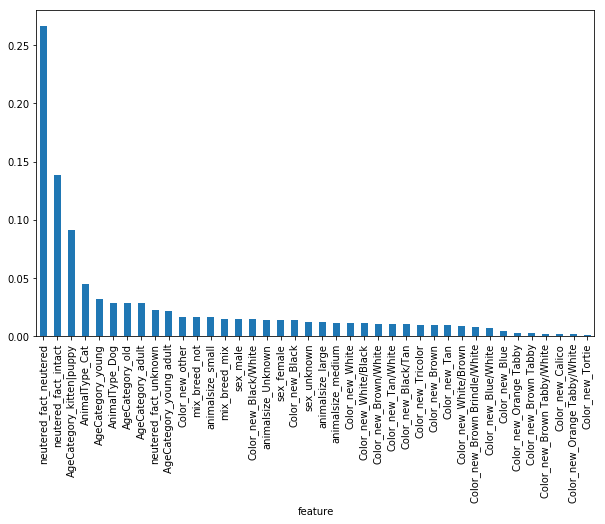

In [37]:
featureImportance = pd.DataFrame({"feature": X_train.columns, "importance": model.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(10, 6));

Помимо обычной визуализации признаков мы можем использовать также библиотеку SHAP для визуализации важности переменных при принятии решения в относительно плохо интерпретируемых моделях. 
Расчет методики базируется на значении Шэпли. Подробнее описано здесь: 
https://habr.com/ru/post/428213/

С помощью методики можно визуализировать важность признаков в принятии решения как в общем в модели, так и в каждом конкретном случае (наблюдении). Второе лучше делать для бинарной классификации или для регрессионных задач :)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


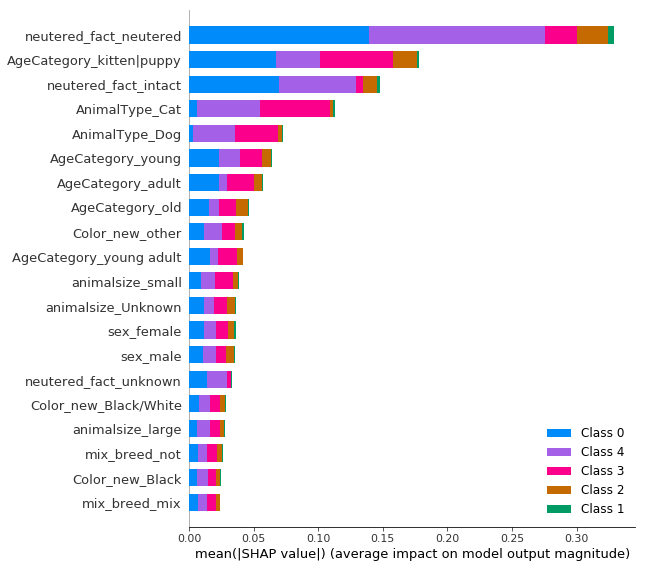

In [41]:
#пример использоваия для мультикласса
#https://github.com/slundberg/shap/issues/367
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train,approximate=True)
shap.summary_plot(shap_values, X_train, plot_type="bar")